In [2]:
!pip install nba_api

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 kB 4.2 MB/s eta 0:00:00


In [ ]:
from nba_api.stats.endpoints import leaguegamefinder
import pandas as pd

# Use LeagueGameFinder to fetch historical games
game_finder = leaguegamefinder.LeagueGameFinder()
games = game_finder.get_data_frames()[0]  # Get the first DataFrame

# List of NBA team abbreviations (exclude G League teams)
nba_team_abbreviations = [
    'ATL', 'BOS', 'BKN', 'CHA', 'CHI', 'CLE', 'DAL', 'DEN', 'DET', 'GSW',
    'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 'MIL', 'MIN', 'NOP', 'NYK',
    'OKC', 'ORL', 'PHI', 'PHX', 'POR', 'SAC', 'SAS', 'TOR', 'UTA', 'WAS'
]

# Filter out G League games by keeping only NBA team abbreviations
nba_games = games[games['TEAM_ABBREVIATION'].isin(nba_team_abbreviations)]

# Sort games by date (most recent first)
nba_games['GAME_DATE'] = pd.to_datetime(nba_games['GAME_DATE'])
nba_games = nba_games.sort_values(by='GAME_DATE', ascending=False)

# Filter to the last 100 NBA games
last_100_nba_games = nba_games.head(100)

# Save to a CSV file (optional)
last_100_nba_games.to_csv('last_100_nba_games.csv', index=False)

# Display the DataFrame
print(last_100_nba_games.head())

   SEASON_ID     TEAM_ID TEAM_ABBREVIATION               TEAM_NAME  \
0      22024  1610612743               DEN          Denver Nuggets   
3      22024  1610612754               IND          Indiana Pacers   
1      22024  1610612750               MIN  Minnesota Timberwolves   
2      22024  1610612759               SAS       San Antonio Spurs   
13     22024  1610612739               CLE     Cleveland Cavaliers   

       GAME_ID  GAME_DATE      MATCHUP WL  MIN  PTS  ...  FT_PCT  OREB  DREB  \
0   0022400634 2025-01-25    DEN @ MIN  L  239  104  ...   0.538    14    22   
3   0022400633 2025-01-25    IND @ SAS  W  240  136  ...   0.929    16    34   
1   0022400634 2025-01-25  MIN vs. DEN  W  238  133  ...   0.867    18    27   
2   0022400633 2025-01-25    IND @ SAS  L  241   98  ...   0.680    15    29   
13  0022400631 2025-01-24    CLE @ PHI  L  240  129  ...   0.737    10    27   

    REB  AST  STL  BLK  TOV  PF  PLUS_MINUS  
0    36   32    7    3   19  13       -29.0  
3    5

<ipython-input-3-1c467760d8d7>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nba_games['GAME_DATE'] = pd.to_datetime(nba_games['GAME_DATE'])


In [ ]:
import pandas as pd

# Load the last 100 NBA games (if not already loaded)
last_100_nba_games = pd.read_csv('last_100_nba_games.csv')

# Group by game ID
grouped_games = last_100_nba_games.groupby('GAME_ID')

# Initialize a list to store training data
training_data = []

# Loop through each game
for game_id, game_data in grouped_games:
    # Ensure there are exactly 2 rows (one for each team)
    if len(game_data) != 2:
        continue

    # Extract stats for both teams
    team1 = game_data.iloc[0]
    team2 = game_data.iloc[1]

    # Create composite stats for each team
    team1_stats = {
        'TEAM': team1['TEAM_ABBREVIATION'],
        'PTS': team1['PTS'],
        'REB': team1['REB'],
        'AST': team1['AST'],
        'STL': team1['STL'],
        'BLK': team1['BLK'],
        'TOV': team1['TOV'],
        'FG_PCT': team1['FG_PCT'],
        '3P_PCT': team1['FG3_PCT'],
        'FT_PCT': team1['FT_PCT']
    }

    team2_stats = {
        'TEAM': team2['TEAM_ABBREVIATION'],
        'PTS': team2['PTS'],
        'REB': team2['REB'],
        'AST': team2['AST'],
        'STL': team2['STL'],
        'BLK': team2['BLK'],
        'TOV': team2['TOV'],
        'FG_PCT': team2['FG_PCT'],
        '3P_PCT': team2['FG3_PCT'],
        'FT_PCT': team2['FT_PCT']
    }

    # Determine the game outcome (1 if team1 wins, 0 if team2 wins)
    if team1['WL'] == 'W':
        outcome = 1
    else:
        outcome = 0

    # Combine stats into a single row for training
    training_row = {
        'GAME_ID': game_id,
        'TEAM1': team1_stats['TEAM'],
        'TEAM2': team2_stats['TEAM'],
        'TEAM1_PTS': team1_stats['PTS'],
        'TEAM2_PTS': team2_stats['PTS'],
        'TEAM1_REB': team1_stats['REB'],
        'TEAM2_REB': team2_stats['REB'],
        'TEAM1_AST': team1_stats['AST'],
        'TEAM2_AST': team2_stats['AST'],
        'TEAM1_STL': team1_stats['STL'],
        'TEAM2_STL': team2_stats['STL'],
        'TEAM1_BLK': team1_stats['BLK'],
        'TEAM2_BLK': team2_stats['BLK'],
        'TEAM1_TOV': team1_stats['TOV'],
        'TEAM2_TOV': team2_stats['TOV'],
        'TEAM1_FG_PCT': team1_stats['FG_PCT'],
        'TEAM2_FG_PCT': team2_stats['FG_PCT'],
        'TEAM1_3P_PCT': team1_stats['3P_PCT'],
        'TEAM2_3P_PCT': team2_stats['3P_PCT'],
        'TEAM1_FT_PCT': team1_stats['FT_PCT'],
        'TEAM2_FT_PCT': team2_stats['FT_PCT'],
        'OUTCOME': outcome
    }

    # Append to the training data
    training_data.append(training_row)

# Convert the training data to a DataFrame
training_df = pd.DataFrame(training_data)

# Save to a CSV file (optional)
training_df.to_csv('nba_training_data.csv', index=False)

# Display the DataFrame
print(training_df.head())

    GAME_ID TEAM1 TEAM2  TEAM1_PTS  TEAM2_PTS  TEAM1_REB  TEAM2_REB  \
0  22400586   PHX   DET        125        121         50         43   
1  22400587   BOS   ATL        115        119         53         55   
2  22400588   PHI   IND        102        115         32         50   
3  22400589   GSW   WAS        122        114         55         44   
4  22400590   MIN   CLE        117        124         42         47   

   TEAM1_AST  TEAM2_AST  TEAM1_STL  ...  TEAM2_BLK  TEAM1_TOV  TEAM2_TOV  \
0         25         22          6  ...          3          9          9   
1         23         27         13  ...         10         14         17   
2         21         30          8  ...          4          9         17   
3         24         24          6  ...          2          9         13   
4         27         27          4  ...          1          7          7   

   TEAM1_FG_PCT  TEAM2_FG_PCT  TEAM1_3P_PCT  TEAM2_3P_PCT  TEAM1_FT_PCT  \
0         0.500         0.468         0.2

In [ ]:
# Features (X) and labels (y)
X = training_df.drop(columns=['GAME_ID', 'TEAM1', 'TEAM2', 'OUTCOME'])  # Drop non-feature columns
y = training_df['OUTCOME']  # Labels (1 if TEAM1 wins, 0 if TEAM2 wins)

# Check for missing values
print(X.isnull().sum())  # Ensure there are no missing values

# If there are missing values, handle them (e.g., fill with mean)
X = X.fillna(X.mean())

TEAM1_PTS       0
TEAM2_PTS       0
TEAM1_REB       0
TEAM2_REB       0
TEAM1_AST       0
TEAM2_AST       0
TEAM1_STL       0
TEAM2_STL       0
TEAM1_BLK       0
TEAM2_BLK       0
TEAM1_TOV       0
TEAM2_TOV       0
TEAM1_FG_PCT    0
TEAM2_FG_PCT    0
TEAM1_3P_PCT    0
TEAM2_3P_PCT    0
TEAM1_FT_PCT    0
TEAM2_FT_PCT    0
dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

Training set size: (38, 18)
Testing set size: (10, 18)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.90

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.83      1.00      0.91         5

    accuracy                           0.90        10
   macro avg       0.92      0.90      0.90        10
weighted avg       0.92      0.90      0.90        10


Confusion Matrix:
[[4 1]
 [0 5]]


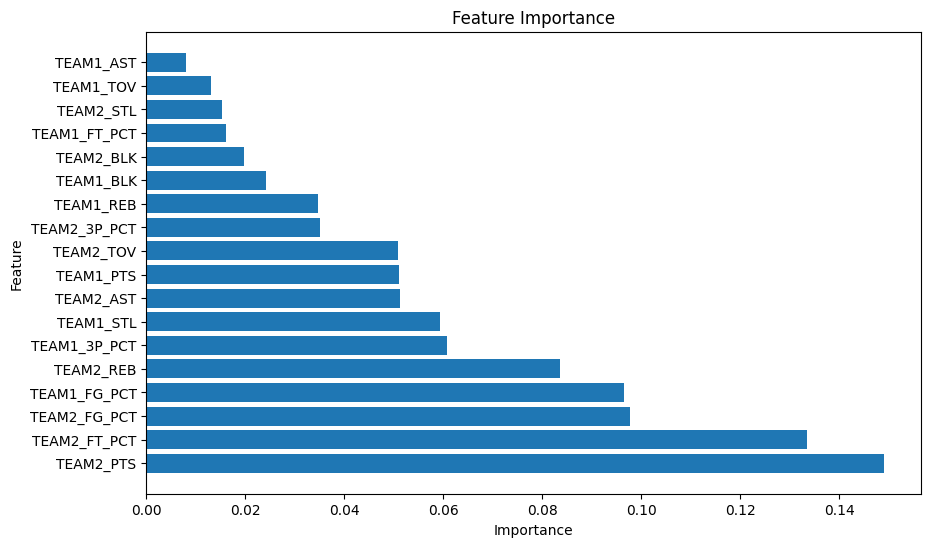

In [ ]:
import matplotlib.pyplot as plt

# Get feature importances
importances = model.feature_importances_
feature_names = X.columns

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [ ]:
# Example: New game stats (replace with actual data)
new_game_stats = {
    'TEAM1_PTS': 110, 'TEAM2_PTS': 105,
    'TEAM1_REB': 45, 'TEAM2_REB': 42,
    'TEAM1_AST': 25, 'TEAM2_AST': 23,
    'TEAM1_STL': 8, 'TEAM2_STL': 7,
    'TEAM1_BLK': 5, 'TEAM2_BLK': 4,
    'TEAM1_TOV': 12, 'TEAM2_TOV': 14,
    'TEAM1_FG_PCT': 0.494, 'TEAM2_FG_PCT': 0.455,
    'TEAM1_3P_PCT': 0.380, 'TEAM2_3P_PCT': 0.350,
    'TEAM1_FT_PCT': 0.800, 'TEAM2_FT_PCT': 0.750
}

# Convert to DataFrame
new_game_df = pd.DataFrame([new_game_stats])

# Make prediction
prediction = model.predict_proba(new_game_df)
print(f"Probability of TEAM1 winning: {prediction[0][1]:.2f}")
print(f"Probability of TEAM2 winning: {prediction[0][0]:.2f}")

Probability of TEAM1 winning: 0.85
Probability of TEAM2 winning: 0.15


In [ ]:
import joblib

# Save the model
joblib.dump(model, 'nba_game_predictor.pkl')

# Load the model (in the future)
# model = joblib.load('nba_game_predictor.pkl')

['nba_game_predictor.pkl']

In [14]:
!pip install nba_api
from nba_api.live.nba.endpoints import scoreboard

# Fetch upcoming games
scoreboard_data = scoreboard.ScoreBoard()
upcoming_games = scoreboard_data.games.get_dict()

# Display upcoming games
for game in upcoming_games:
    home_team = game['homeTeam']['teamName']
    away_team = game['awayTeam']['teamName']
    game_time = game['gameTimeUTC']
    print(f"{away_team} @ {home_team} - {game_time}")

Thunder @ Trail Blazers - 2025-01-26T23:00:00Z


In [15]:
# RUN THIS FOR SEASON AVG

from nba_api.stats.endpoints import leaguedashteamstats
from nba_api.stats.static import teams
import pandas as pd

# Fetch current season team stats
team_stats = leaguedashteamstats.LeagueDashTeamStats(season='2024-25', timeout=30).get_data_frames()[0]

# Get all NBA teams
nba_teams = teams.get_teams()

# Map team IDs to team names
team_id_to_name = {team['id']: team['full_name'].split()[-1] for team in nba_teams}

# Extract relevant stats for each team and calculate per-game averages
team_avg_stats = {}
for _, row in team_stats.iterrows():
    team_id = row['TEAM_ID']
    team_name = team_id_to_name.get(team_id, f"Unknown Team {team_id}")
    games_played = row['GP']  # Number of games played

    # Calculate per-game averages
    team_avg_stats[team_name] = {
        'PTS': row['PTS'] / games_played,
        'REB': row['REB'] / games_played,
        'AST': row['AST'] / games_played,
        'STL': row['STL'] / games_played,
        'BLK': row['BLK'] / games_played,
        'TOV': row['TOV'] / games_played,
        'FG_PCT': row['FG_PCT'],  # FG% is already a percentage, no need to divide
        'FG3_PCT': row['FG3_PCT'],  # 3P% is already a percentage, no need to divide
        'FT_PCT': row['FT_PCT']  # FT% is already a percentage, no need to divide
    }

# Display team average stats
for team, stats in team_avg_stats.items():
    print(f"{team}: {stats}")

Hawks: {'PTS': 116.28888888888889, 'REB': 45.37777777777778, 'AST': 29.333333333333332, 'STL': 10.444444444444445, 'BLK': 5.266666666666667, 'TOV': 16.2, 'FG_PCT': 0.46, 'FG3_PCT': 0.348, 'FT_PCT': 0.777}
Celtics: {'PTS': 117.28260869565217, 'REB': 45.108695652173914, 'AST': 25.543478260869566, 'STL': 7.565217391304348, 'BLK': 5.717391304347826, 'TOV': 11.76086956521739, 'FG_PCT': 0.456, 'FG3_PCT': 0.364, 'FT_PCT': 0.79}
Nets: {'PTS': 105.67391304347827, 'REB': 40.45652173913044, 'AST': 24.934782608695652, 'STL': 7.3478260869565215, 'BLK': 3.760869565217391, 'TOV': 15.695652173913043, 'FG_PCT': 0.441, 'FG3_PCT': 0.356, 'FT_PCT': 0.795}
Hornets: {'PTS': 107.54761904761905, 'REB': 46.07142857142857, 'AST': 23.928571428571427, 'STL': 8.214285714285714, 'BLK': 4.880952380952381, 'TOV': 15.880952380952381, 'FG_PCT': 0.431, 'FG3_PCT': 0.345, 'FT_PCT': 0.775}
Bulls: {'PTS': 116.43478260869566, 'REB': 45.80434782608695, 'AST': 28.891304347826086, 'STL': 7.543478260869565, 'BLK': 4.695652173913

In [18]:
# RUN THIS FOR LAST 15 GAMES AVG

from nba_api.stats.endpoints import teamgamelog
from nba_api.stats.static import teams
import pandas as pd

# Get all NBA teams
nba_teams = teams.get_teams()

# Initialize a dictionary to store team stats
team_last_15_stats = {}

# Fetch game logs and calculate last 15 games' averages
for team in nba_teams:
    team_id = team['id']
    team_name = team['full_name'].split()[-1]  # Extract team name (e.g., "Celtics")

    try:
        # Fetch the team's game log
        game_log = teamgamelog.TeamGameLog(team_id=team_id, season='2024-25').get_data_frames()[0]

        # Ensure the games are sorted by date (most recent first)
        game_log['GAME_DATE'] = pd.to_datetime(game_log['GAME_DATE'])
        game_log = game_log.sort_values(by='GAME_DATE', ascending=False)

        # Get the last 15 games
        last_15_games = game_log.head(15)

        # Calculate average stats for the last 15 games
        team_last_15_stats[team_name] = {
            'PTS': last_15_games['PTS'].mean(),
            'REB': last_15_games['REB'].mean(),
            'AST': last_15_games['AST'].mean(),
            'STL': last_15_games['STL'].mean(),
            'BLK': last_15_games['BLK'].mean(),
            'TOV': last_15_games['TOV'].mean(),
            'FG_PCT': last_15_games['FG_PCT'].mean(),
            'FG3_PCT': last_15_games['FG3_PCT'].mean(),
            'FT_PCT': last_15_games['FT_PCT'].mean()
        }
        print(f"Processed stats for {team_name}")
    except Exception as e:
        print(f"Error fetching stats for {team_name}: {e}")

# Display the last 15 games' averages
for team, stats in team_last_15_stats.items():
    print(f"{team}: {stats}")

<ipython-input-18-8010162ec053>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  game_log['GAME_DATE'] = pd.to_datetime(game_log['GAME_DATE'])
<ipython-input-18-8010162ec053>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  game_log['GAME_DATE'] = pd.to_datetime(game_log['GAME_DATE'])
<ipython-input-18-8010162ec053>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  game_log['GAME_DATE'] = pd.to_datetime(game_log['GAME_DATE'])
<ipython-input-18-8010162ec053>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To

Processed stats for Hawks
Processed stats for Celtics
Processed stats for Cavaliers
Processed stats for Pelicans


<ipython-input-18-8010162ec053>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  game_log['GAME_DATE'] = pd.to_datetime(game_log['GAME_DATE'])
<ipython-input-18-8010162ec053>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  game_log['GAME_DATE'] = pd.to_datetime(game_log['GAME_DATE'])
<ipython-input-18-8010162ec053>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  game_log['GAME_DATE'] = pd.to_datetime(game_log['GAME_DATE'])
<ipython-input-18-8010162ec053>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To

Processed stats for Bulls
Processed stats for Mavericks
Processed stats for Nuggets
Processed stats for Warriors


<ipython-input-18-8010162ec053>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  game_log['GAME_DATE'] = pd.to_datetime(game_log['GAME_DATE'])
<ipython-input-18-8010162ec053>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  game_log['GAME_DATE'] = pd.to_datetime(game_log['GAME_DATE'])
<ipython-input-18-8010162ec053>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  game_log['GAME_DATE'] = pd.to_datetime(game_log['GAME_DATE'])
<ipython-input-18-8010162ec053>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To

Processed stats for Rockets
Processed stats for Clippers
Processed stats for Lakers
Processed stats for Heat


<ipython-input-18-8010162ec053>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  game_log['GAME_DATE'] = pd.to_datetime(game_log['GAME_DATE'])
<ipython-input-18-8010162ec053>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  game_log['GAME_DATE'] = pd.to_datetime(game_log['GAME_DATE'])
<ipython-input-18-8010162ec053>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  game_log['GAME_DATE'] = pd.to_datetime(game_log['GAME_DATE'])


Processed stats for Bucks
Processed stats for Timberwolves
Processed stats for Nets
Error fetching stats for Knicks: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)
Error fetching stats for Magic: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)
Error fetching stats for Pacers: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)
Error fetching stats for 76ers: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)
Processed stats for Suns
Processed stats for Blazers


<ipython-input-18-8010162ec053>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  game_log['GAME_DATE'] = pd.to_datetime(game_log['GAME_DATE'])
<ipython-input-18-8010162ec053>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  game_log['GAME_DATE'] = pd.to_datetime(game_log['GAME_DATE'])
<ipython-input-18-8010162ec053>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  game_log['GAME_DATE'] = pd.to_datetime(game_log['GAME_DATE'])
<ipython-input-18-8010162ec053>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To

Processed stats for Kings
Processed stats for Spurs
Processed stats for Thunder
Processed stats for Raptors


<ipython-input-18-8010162ec053>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  game_log['GAME_DATE'] = pd.to_datetime(game_log['GAME_DATE'])
<ipython-input-18-8010162ec053>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  game_log['GAME_DATE'] = pd.to_datetime(game_log['GAME_DATE'])
<ipython-input-18-8010162ec053>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  game_log['GAME_DATE'] = pd.to_datetime(game_log['GAME_DATE'])
<ipython-input-18-8010162ec053>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To

Processed stats for Jazz
Processed stats for Grizzlies
Processed stats for Wizards
Processed stats for Pistons
Processed stats for Hornets
Hawks: {'PTS': 116.06666666666666, 'REB': 44.0, 'AST': 28.8, 'STL': 11.0, 'BLK': 5.0, 'TOV': 14.066666666666666, 'FG_PCT': 0.4547333333333334, 'FG3_PCT': 0.3421333333333333, 'FT_PCT': 0.7707999999999999}
Celtics: {'PTS': 112.4, 'REB': 44.2, 'AST': 25.466666666666665, 'STL': 7.666666666666667, 'BLK': 6.133333333333334, 'TOV': 10.933333333333334, 'FG_PCT': 0.4547333333333334, 'FG3_PCT': 0.3600666666666667, 'FT_PCT': 0.7561999999999999}
Cavaliers: {'PTS': 122.53333333333333, 'REB': 44.666666666666664, 'AST': 29.933333333333334, 'STL': 6.933333333333334, 'BLK': 4.733333333333333, 'TOV': 12.333333333333334, 'FG_PCT': 0.4826666666666667, 'FG3_PCT': 0.3809333333333333, 'FT_PCT': 0.7846666666666666}
Pelicans: {'PTS': 116.06666666666666, 'REB': 42.666666666666664, 'AST': 27.533333333333335, 'STL': 9.466666666666667, 'BLK': 6.133333333333334, 'TOV': 12.266666

<ipython-input-18-8010162ec053>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  game_log['GAME_DATE'] = pd.to_datetime(game_log['GAME_DATE'])
<ipython-input-18-8010162ec053>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  game_log['GAME_DATE'] = pd.to_datetime(game_log['GAME_DATE'])
<ipython-input-18-8010162ec053>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  game_log['GAME_DATE'] = pd.to_datetime(game_log['GAME_DATE'])


In [16]:
import pickle

# Load team_avg_stats from the file
with open('team_avg_stats.pkl', 'rb') as f:
    team_avg_stats = pickle.load(f)

# Display the loaded data
print("Loaded team_avg_stats:")
for team, stats in team_avg_stats.items():
    print(f"{team}: {stats}")

Loaded team_avg_stats:
Hawks: {'PTS': 116.28888888888889, 'REB': 45.37777777777778, 'AST': 29.333333333333332, 'STL': 10.444444444444445, 'BLK': 5.266666666666667, 'TOV': 16.2, 'FG_PCT': 0.46, 'FG3_PCT': 0.348, 'FT_PCT': 0.777}
Celtics: {'PTS': 117.28260869565217, 'REB': 45.108695652173914, 'AST': 25.543478260869566, 'STL': 7.565217391304348, 'BLK': 5.717391304347826, 'TOV': 11.76086956521739, 'FG_PCT': 0.456, 'FG3_PCT': 0.364, 'FT_PCT': 0.79}
Nets: {'PTS': 105.67391304347827, 'REB': 40.45652173913044, 'AST': 24.934782608695652, 'STL': 7.3478260869565215, 'BLK': 3.760869565217391, 'TOV': 15.695652173913043, 'FG_PCT': 0.441, 'FG3_PCT': 0.356, 'FT_PCT': 0.795}
Hornets: {'PTS': 107.54761904761905, 'REB': 46.07142857142857, 'AST': 23.928571428571427, 'STL': 8.214285714285714, 'BLK': 4.880952380952381, 'TOV': 15.880952380952381, 'FG_PCT': 0.431, 'FG3_PCT': 0.345, 'FT_PCT': 0.775}
Bulls: {'PTS': 116.43478260869566, 'REB': 45.80434782608695, 'AST': 28.891304347826086, 'STL': 7.543478260869565

In [40]:
import pandas as pd

# Display upcoming games
counter = 0
for game in upcoming_games:
    home_team = game['homeTeam']['teamName']
    away_team = game['awayTeam']['teamName']
    print(f"{counter}. {away_team} @ {home_team}")
    counter += 1

# Example: Prepare data for an upcoming game
upcoming_game = upcoming_games[0]  # First upcoming game
home_team = upcoming_game['homeTeam']['teamName']
away_team = upcoming_game['awayTeam']['teamName']

home_team = 'Wizards'
away_team = 'Mavericks'

# Get average stats for both teams
home_stats = team_last_15_stats[home_team]
away_stats = team_last_15_stats[away_team]

# Create a row of features
game_features = {
    'TEAM1_PTS': home_stats['PTS'], 'TEAM2_PTS': away_stats['PTS'],
    'TEAM1_REB': home_stats['REB'], 'TEAM2_REB': away_stats['REB'],
    'TEAM1_AST': home_stats['AST'], 'TEAM2_AST': away_stats['AST'],
    'TEAM1_STL': home_stats['STL'], 'TEAM2_STL': away_stats['STL'],
    'TEAM1_BLK': home_stats['BLK'], 'TEAM2_BLK': away_stats['BLK'],
    'TEAM1_TOV': home_stats['TOV'], 'TEAM2_TOV': away_stats['TOV'],
    'TEAM1_FG_PCT': home_stats['FG_PCT'], 'TEAM2_FG_PCT': away_stats['FG_PCT'],
    'TEAM1_3P_PCT': home_stats['FG3_PCT'], 'TEAM2_3P_PCT': away_stats['FG3_PCT'],
    'TEAM1_FT_PCT': home_stats['FT_PCT'], 'TEAM2_FT_PCT': away_stats['FT_PCT']
}

# Convert to DataFrame
game_df = pd.DataFrame([game_features])

# Load the trained model (if not already loaded)
import joblib
model = joblib.load('nba_game_predictor.pkl')

# Make prediction
prediction = model.predict_proba(game_df)
print(f"Probability of {home_team} winning: {prediction[0][1]:.2f}")
print(f"Probability of {away_team} winning: {prediction[0][0]:.2f}")

0. Thunder @ Trail Blazers
Probability of Wizards winning: 0.59
Probability of Mavericks winning: 0.41


In [41]:
# TOOL: AMERICAN ODDS TO %
def odds_to_probability(odds):
    if odds > 0:
        probability = 100 / (odds + 100)
    else:
        probability = -odds / (-odds + 100)
    return probability

# Example usage
positive_odds = 455
negative_odds = -625

positive_probability = odds_to_probability(positive_odds)
negative_probability = odds_to_probability(negative_odds)

print(f"Probability for + odds: {positive_probability:.4f} or {positive_probability*100:.2f}%")
print(f"Probability for - odds: {negative_probability:.4f} or {negative_probability*100:.2f}%")

Probability for + odds: 0.1802 or 18.02%
Probability for - odds: 0.8621 or 86.21%


In [20]:
# TOOL: % TO AMERICAN ODDS
def probability_to_american_odds(probability):
    """Convert a probability to American odds format."""
    if probability < 0 or probability > 1:
        raise ValueError("Probability must be between 0 and 1.")

    if probability < 0.5:
        odds = (100 / probability) - 100
        return f"+{int(round(odds))}"
    else:
        odds = (probability / (1 - probability)) * 100
        return f"-{int(round(odds))}"

# Example usage
probability = 0.37
american_odds = probability_to_american_odds(probability)
print(f"American Odds: {american_odds}")
probability = 0.63
american_odds = probability_to_american_odds(probability)
print(f"American Odds: {american_odds}")

American Odds: +170
American Odds: -170


In [17]:
import pickle

# Save team_avg_stats to a file using pickle
with open('team_avg_stats.pkl', 'wb') as f:
    pickle.dump(team_avg_stats, f)

print("team_avg_stats saved to 'team_avg_stats.pkl'")

team_avg_stats saved to 'team_avg_stats.pkl'
